# Desafio Tech Challenge

Criar um modelo preditivo, utilizando algoritmo de regressão, que prever o preço dos encargos de um seguro de saúde

##Importação de dados e breve estudo da base

Utilizaremos uma base retirada do site da kaggle, chamada Healthcare Insurance.


Caso quiser realizar o download, está disponível no link abaixo:
https://www.kaggle.com/datasets/willianoliveiragibin/healthcare-insurance


In [ ]:
import pandas as pd

In [ ]:
dados = pd.read_csv('insurance.csv')

In [ ]:
dados

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [ ]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Pela a info obtida podemos observar que temos nenhum campo nulo nessa base.

In [ ]:
dados.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Aqui com essa amostragem, já podemos identificar que a coluna charge é a nossa target, que iremos utilizar nos modelos.

In [ ]:
set(dados['sex'])

{'female', 'male'}

In [ ]:
set(dados['smoker'])

{'no', 'yes'}

In [ ]:
set(dados['region'])

{'northeast', 'northwest', 'southeast', 'southwest'}

Temos aqui 3 variáveis categóricas:

*   Sex: é referente ao sexo biológico do cliente, e tem valores binários
*   Smoker: é referente se o cliente é fumante ou não, ou seja, também apresenta valores binários
*   Region: é referente a região que o cliente reside, e podemos observar que temos mais de 2 valores na amostragem

Com isso, vemos aqui que temos que fazer duas tratativas diferentes, para as variáveis categóricas binárias, iremos utilizar o LabelEncoder. E para o dado de região iremos utilizar a técnica OneHotEncoding

##Tratativas de pré-processamento de dados


In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
colunas = ['sex', 'smoker']

label_encoder = LabelEncoder()

dados_encoded = pd.DataFrame(dados)

for col in colunas:
  dados_encoded[col] = label_encoder.fit_transform(dados[col])

In [ ]:
dados_encoded.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,southwest,16884.92400
1,18,1,33.770,1,0,southeast,1725.55230
2,28,1,33.000,3,0,southeast,4449.46200
3,33,1,22.705,0,0,northwest,21984.47061
4,32,1,28.880,0,0,northwest,3866.85520


In [ ]:
#Não usamos essas novas colunas no treinamento e o resultado foi melhor
dummy_region = pd.get_dummies(dados['region'], prefix='dummy_region', dtype=int)
dados_encoded = pd.concat([dados_encoded, dummy_region], axis=1)
dados_encoded.drop(['region'], axis=1, inplace=True)

In [ ]:
dados_encoded.head()

,age,sex,bmi,children,smoker,charges,dummy_region_northeast,dummy_region_northwest,dummy_region_southeast,dummy_region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,0,1
1,18,1,33.770,1,0,1725.55230,0,0,1,0
2,28,1,33.000,3,0,4449.46200,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,1,0,0


Com esse DataFrame numérico, já podemos extrair a matriz de correlação de valores, para termos uma melhor visualização dos dados

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb

<Axes: >

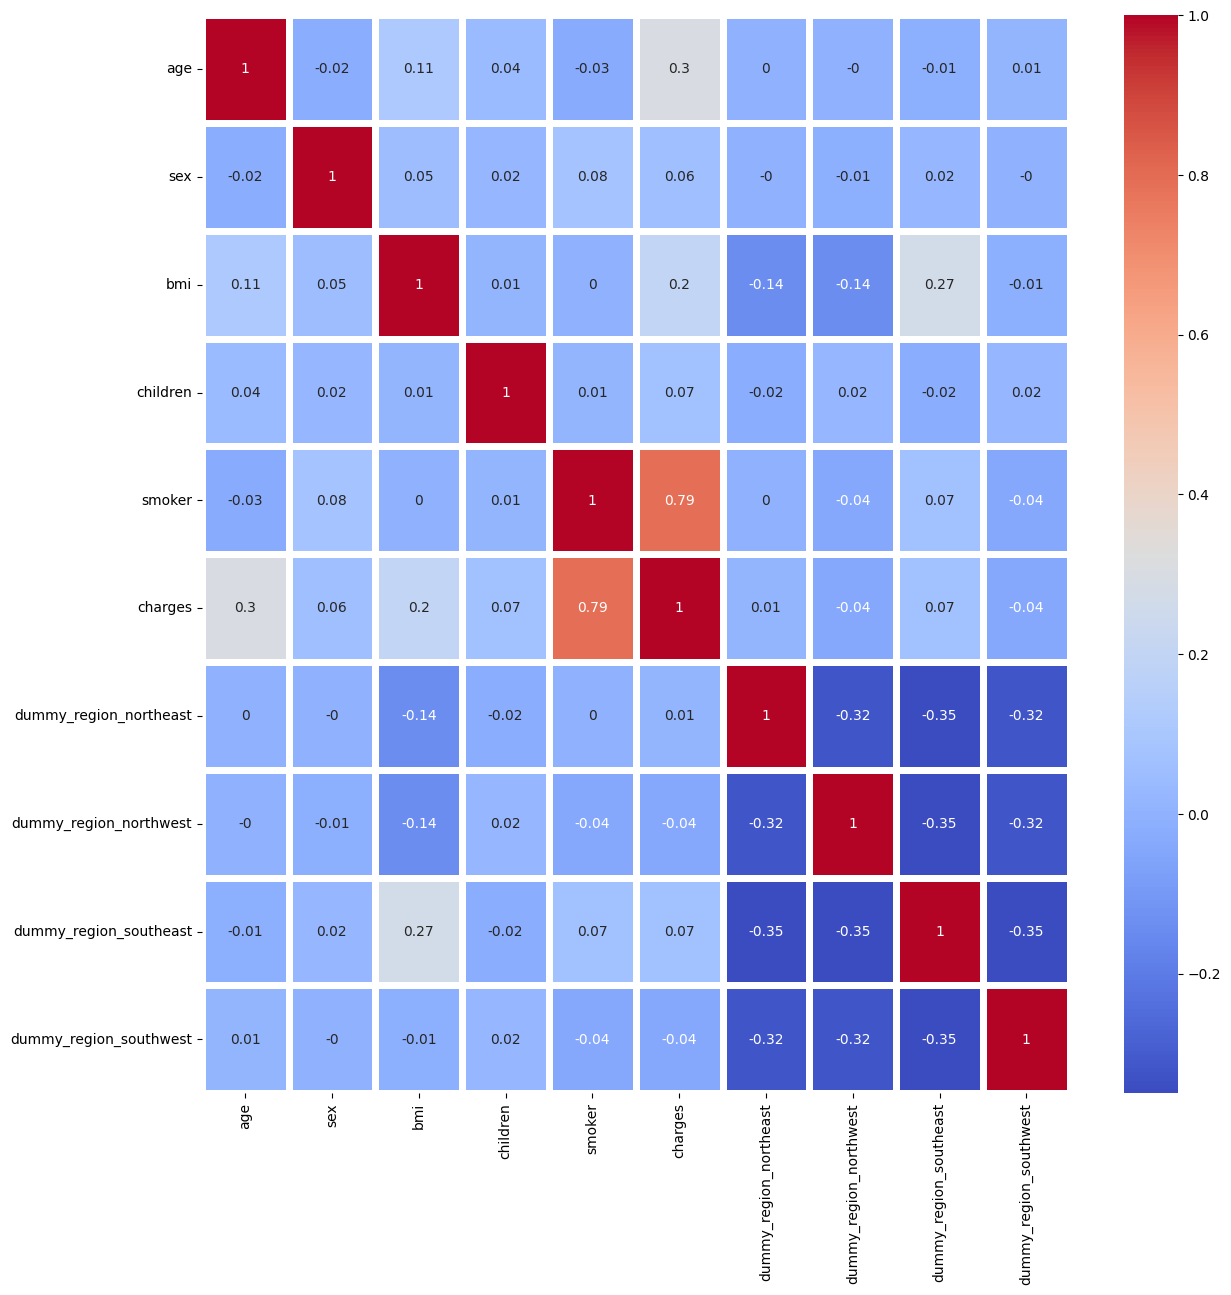

In [ ]:
dados_encoded_corr = dados_encoded.corr().round(2)

fig, ax = plt.subplots(figsize=(14,14))

sb.heatmap(data=dados_encoded_corr, annot=True, linewidths=5, ax=ax, cmap='coolwarm')

Observamos uma alta correlação nos dados de `charges` e `smokers`

Então podemos entender que, fumantes possuem encargos maiores de saúde.

Com essa informação, podemos ter insight para outros tipos de visualização dos dados da base

##Visualização de dados

<Axes: xlabel='sex', ylabel='Count'>

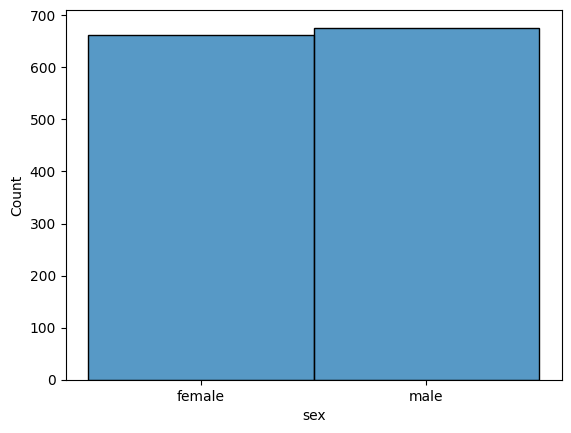

In [ ]:
sb.histplot(data=dados, x='sex')

<Axes: xlabel='children', ylabel='Count'>

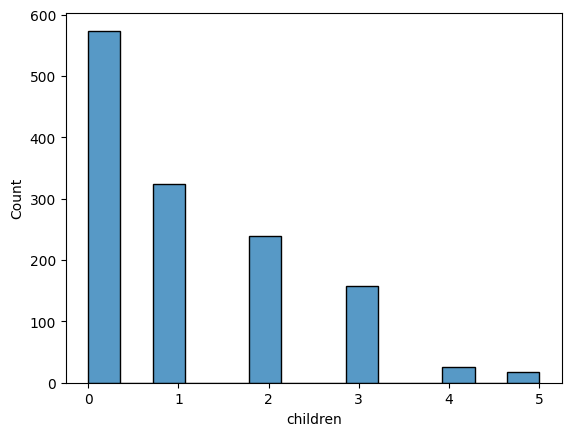

In [ ]:
sb.histplot(data=dados, x='children')

In [ ]:
#teste de hipótese
from scipy.stats import mannwhitneyu
from scipy.stats import shapiro
from scipy.stats import stats

def check_shapiro(df):
  print('---')
  stat, p = shapiro(df)
  print('Estatística de teste: {:.4f}, valor: {}'.format(stat, p))

  if p>0.5:
    print('Não há evidência suficiente para rejeitar a hipótese de normalidade')
  else:
    print('A hipótese de normalidade é rejeitada')

#Teste de hipótese
#H0 - definir uma condição
#H1 - condição contrária ao H0
def check_stats(dados, target, column, value_h0, value_h1, label=[str], title='Distribuição de Fumantes', xlabel='Custo Médico'):
  #no cenário atual a column é o smoker, v1=1 para fumantes e v2=para não fumantes
  df = dados.copy()

  #smoker
  df_h0 = df[df[column]==value_h0]
  #no_smoker
  df_h1 = df[df[column]==value_h1]

  h0 = df_h0[target]
  h1 = df_h1[target]

  plt.figure(figsize=(10,5))

  #grafico de densidade
  #Criando o gráfico de densidade usando ambos dataframes
  sb.kdeplot(data=h0, label=label[0], fill=True, color='orange') #Fumantes
  sb.kdeplot(data=h1, label=label[1], fill=True,  color='lightblue') #Não Fumantes

  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel('Densidade')
  plt.legend()
  plt.show()

  #teste de shapiro
  check_shapiro(h0)
  check_shapiro(h1)

  #check_mannwhitneyu(h0,h1)
  stat, p = mannwhitneyu( h0.sample(len(h0)), h1.sample( len(h1) ), alternative='less')
  print('---')
  print('Estatística de teste U:', stat)
  print('Valor p:', p)

  alpha=0.05
  if p<alpha:
    print('Diferença estatisticamente significante')
  else:
    print('Não há diferença estatisticamente significante')


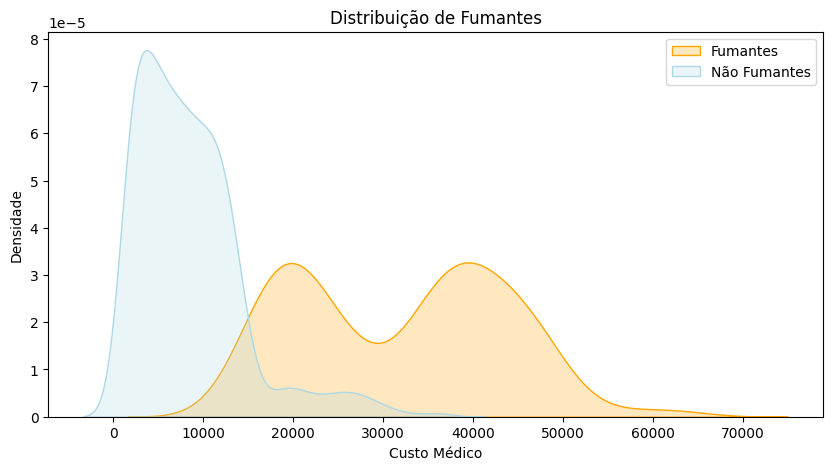

---
Estatística de teste: 0.9396, valor: 3.6255991542333277e-09
A hipótese de normalidade é rejeitada
---
Estatística de teste: 0.8729, valor: 1.4456512848762904e-28
A hipótese de normalidade é rejeitada
---
Estatística de teste U: 284133.0
Valor p: 1.0
Não há diferença estatisticamente significante


In [ ]:
check_stats(dados_encoded, 'charges','smoker', 1, 0, ['Fumantes', 'Não Fumantes'])

<Axes: xlabel='smoker', ylabel='charges'>

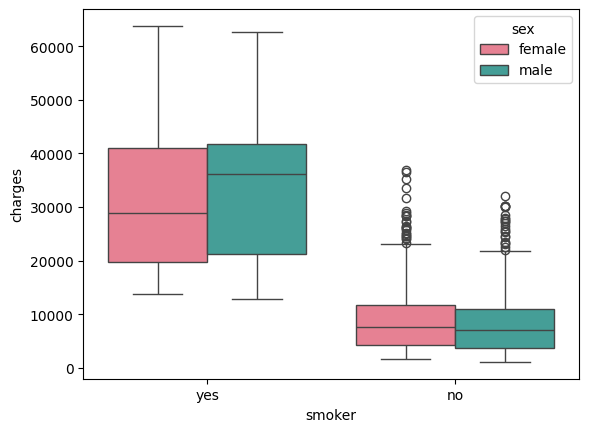

In [ ]:
sb.boxplot(x='smoker', y='charges', data=dados, palette='husl', hue='sex')

<Axes: xlabel='region', ylabel='charges'>

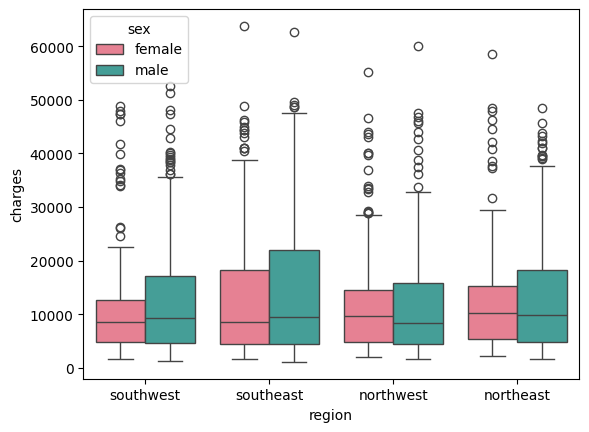

In [ ]:
sb.boxplot(x='region', y='charges', data=dados, palette='husl', hue='sex')

Agora vamos verificar a dispersão dos dados originalmente numéricos

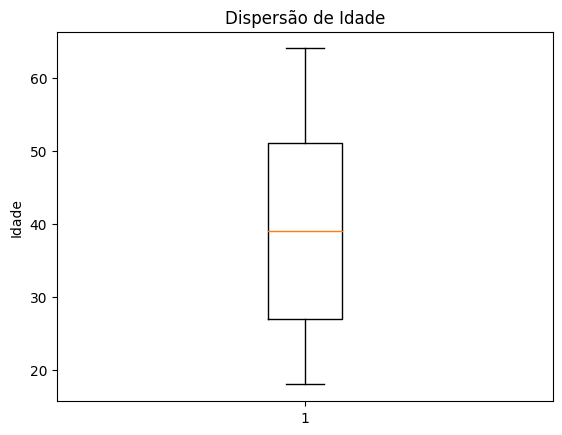

In [ ]:
plt.boxplot(dados['age'])
plt.title('Dispersão de Idade')
plt.ylabel('Idade')
plt.colormaps
plt.show()

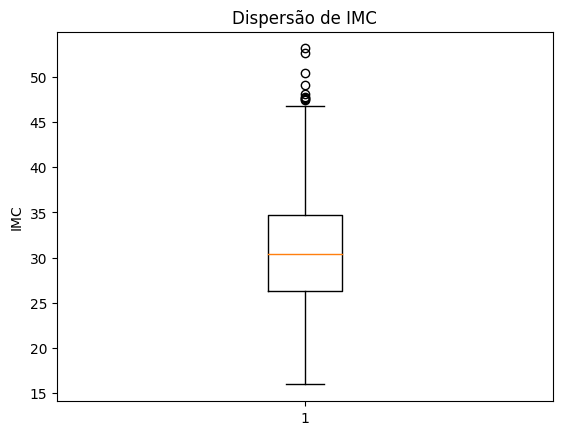

In [ ]:
plt.boxplot(dados['bmi'])
plt.title('Dispersão de IMC')
plt.ylabel('IMC')
plt.show()

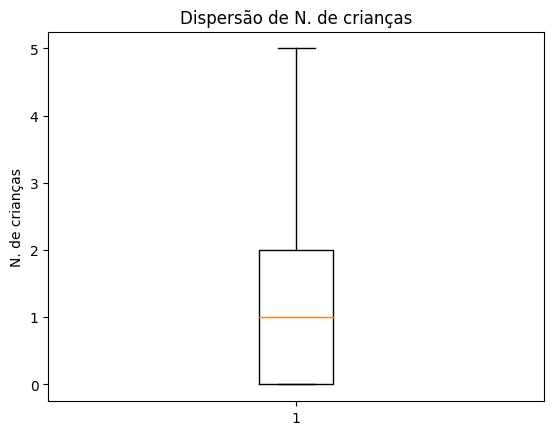

In [ ]:
plt.boxplot(dados['children'])
plt.title('Dispersão de N. de crianças')
plt.ylabel('N. de crianças')
plt.show()

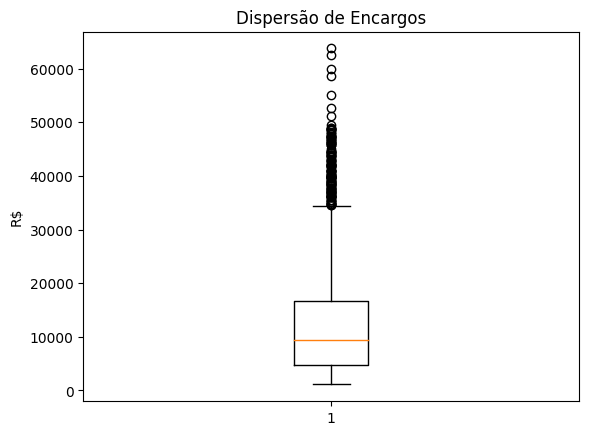

In [ ]:
plt.boxplot(dados['charges'])
plt.title('Dispersão de Encargos')
plt.ylabel('R$')
plt.show()

##Modelos e resultados

Agora que já tivemos os insights das visualizações dos dados. Vamos utilizar os algoritmos de Regressão Linear e a Regressão da Árvore de Decisões para prever os valores de charges



###Separação da base de treino e teste

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x = dados_encoded[['age', 'sex', 'children', 'smoker', 'bmi']]
y = dados_encoded['charges']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42, stratify=dados_encoded['smoker'])

###Regressão Linear

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
modelo_regressao_linear = LinearRegression()

In [ ]:
modelo_regressao_linear.fit(x_train, y_train)

LinearRegression()

In [ ]:
y_pred_linear = modelo_regressao_linear.predict(x_test)

###Árvore de regressão

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
modelo_arvore_regressao = RandomForestRegressor(random_state = 0)
modelo_arvore_regressao.fit(x_train, y_train)

RandomForestRegressor(random_state=0)

In [ ]:
y_pred_arvore = modelo_arvore_regressao.predict(x_test)

###Resultados e comparações

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
def desempenho(titulo, y_test, previsoes):
  # Avaliando o desempenho do modelo
  erro_medio_quadratico = mean_squared_error(y_test, previsoes)
  erro_absoluto_medio = mean_absolute_error(y_test, previsoes)
  r_quadrado = r2_score(y_test, previsoes)


  # Função para calcular o MAPE (erro percentual médio absoluto)
  errors = np.abs(y_test - previsoes)
  relative_errors = errors / np.abs(y_test)
  mape_result  = np.mean(relative_errors) * 100

  # Imprimir o resultado
  print(titulo)
  print(f"O MAPE é: {mape_result:.2f}%")
  print(f'Erro Médio Quadrático: {erro_medio_quadratico}')
  print(f'Erro Absoluto Médio: {erro_absoluto_medio}')
  print(f'R² (coeficiente de determinação): {r_quadrado:.2f}')

In [ ]:
desempenho('Resultados Regressão Linear: \n\n', y_test, y_pred_linear)

Resultados Regressão Linear: 


O MAPE é: 38.85%
Erro Médio Quadrático: 31094398.034585487
Erro Absoluto Médio: 3882.6120882173086
R² (coeficiente de determinação): 0.79


In [ ]:
desempenho('Resultados Árvore de Regressão: \n\n', y_test, y_pred_arvore)

Resultados Árvore de Regressão: 


O MAPE é: 40.16%
Erro Médio Quadrático: 25146401.792942077
Erro Absoluto Médio: 2959.0292599018535
R² (coeficiente de determinação): 0.83


A Árvore de Regressão apresenta um $R^2$ (coeficiente de determinaçao) ligeiramente superior (0.83) em comparação com o da Regressão Linear (0.79), o que sugere que a Árvore de Regressão pode estar explicando uma porcentagem maior da variabilidade dos dados.

Por outro lado, a Regressão Linear tem um MAPE (erro percentual medio absoluto) um pouco menor (38.85%) em comparação com o da Árvore de Regressão (40.16%). Isso significa que, em média, as previsões da Regressão Linear têm um erro percentual menor em relação aos valores reais.

Em termos de MAE (erro absoluto médio), a Árvore de Regressão também apresenta um valor menor (2959.03) em comparação com a Regressão Linear (3882.61), o que indica que, em média, as previsões da Árvore de Regressão têm uma diferença absoluta menor em relação aos valores reais.

Portanto, enquanto a Árvore de Regressão parece explicar melhor a variabilidade dos dados com base no $R^2$, a Regressão Linear tem uma performance ligeiramente melhor em termos de MAPE.

In [ ]:
def plot_previsoes(model_name, y_test, y_pred):

  #valores reais vs predições
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)  # Define a primeira posição do subplot como 1 linha, 2 colunas, e primeira posição
  plt.scatter(y_test, y_pred, c='blue', edgecolors=(0, 0, 0))
  plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=4)
  plt.xlabel('Valores Reais')
  plt.ylabel('Predições')
  plt.title('Valores Reais vs. Predições')

  #Resíduos
  plt.subplot(1, 2, 2)  # Define a segunda posição do subplot como 1 linha, 2 colunas, e segunda posição
  residuals = np.array(y_test) - np.array(y_pred)
  plt.hist(residuals, bins=20, edgecolor='black')
  plt.xlabel('Resíduos')
  plt.ylabel('Frequência')
  plt.title('Histograma dos Resíduos')

  plt.suptitle(f'Comparação entre Valores Reais e Predições - {model_name}')

  plt.tight_layout()
  plt.show()

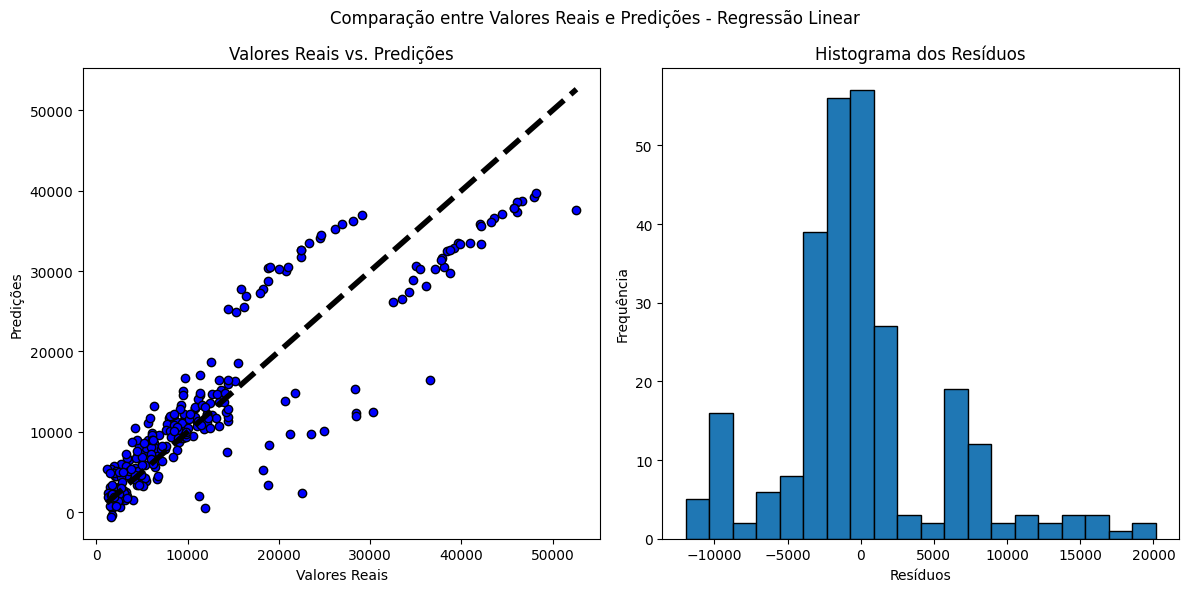

In [ ]:
# Resíduos são as diferenças entre os valores observados e os valores preditos pelo modelo.
plot_previsoes('Regressão Linear', y_test, y_pred_linear)

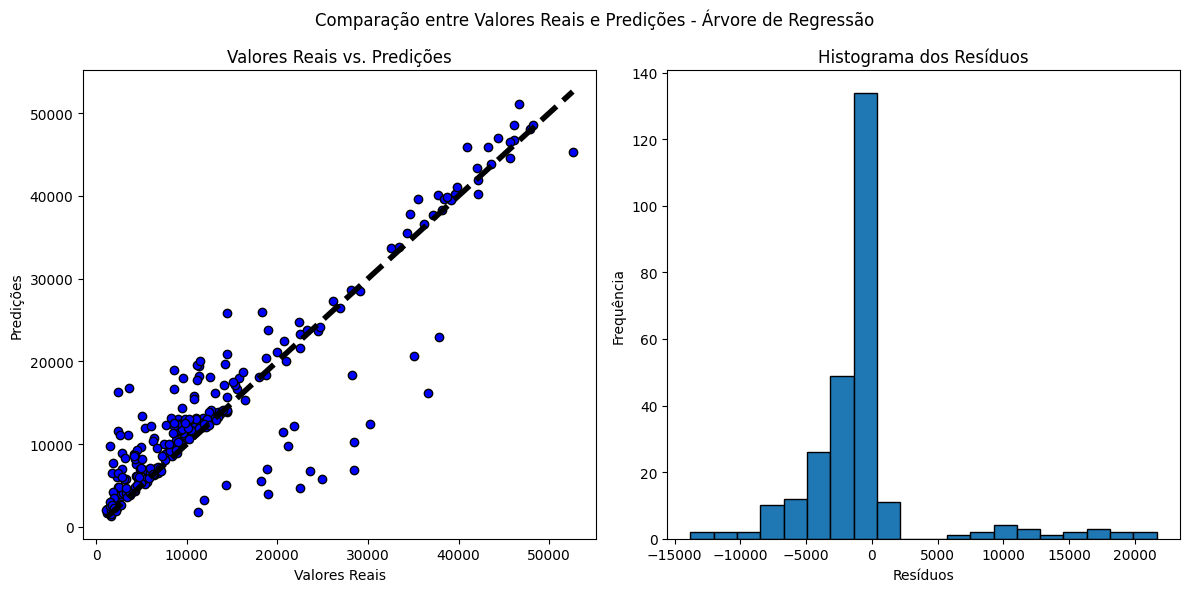

In [ ]:
plot_previsoes('Árvore de Regressão', y_test, y_pred_arvore)